In [1]:
!git clone https://github.com/yash-byte/Self-Driving-Car


fatal: destination path 'Self-Driving-Car' already exists and is not an empty directory.


In [2]:
!ls Self-Driving-Car

driving_log.csv  IMG


In [3]:
!pip3 install imgaug

In [4]:
import ntpath
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense,Convolution2D,MaxPooling2D,Flatten,Dropout
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import random

In [5]:
datadir='Self-Driving-Car'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [6]:
def path_leaf(path):
  head,tail= ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf) 
data['left']=data['left'].apply(path_leaf) 
data['right']=data['right'].apply(path_leaf) 
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

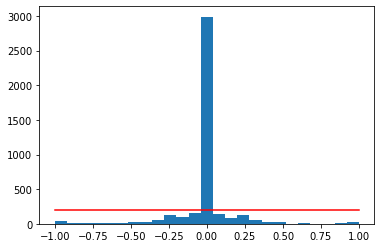

In [7]:
 num_bins=25
 samples_per_bin=200
 hist,bins=np.histogram(data['steering'],num_bins)
 center=(bins[1:]+bins[:-1])*0.5
 plt.bar(center,hist,width=0.08)
 plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin),color='r')

In [8]:
print('total data:', len(data))
removed_list=[]
for j in range(num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if(data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]):
      list_.append(i)
  list_=shuffle(list_)
  list_=list_[samples_per_bin:]
  removed_list.extend(list_)
print('removed size:',len(removed_list))
data.drop(data.index[removed_list],inplace=True)
print('remaining data',len(data))

total data: 4053
removed size: 2790
remaining data 1263


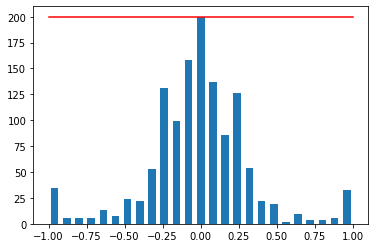

In [9]:
hist,bins=np.histogram(data['steering'],num_bins)
center=(bins[1:]+bins[:-1])*0.5
plt.bar(center,hist,width=0.05 )
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin),color='r')

In [10]:
print(data.iloc[1])
def image_load_steering(datadir,data):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths,steerings

image_paths,steerings=image_load_steering(datadir+'/IMG',data)

center      center_2018_07_16_17_11_44_413.jpg
left        left_2018_07_16_17_11_44_413.jpg  
right       right_2018_07_16_17_11_44_413.jpg 
steering   -0.05                              
throttle    0.642727                          
reverse     0                                 
speed       1.43401                           
Name: 12, dtype: object


In [11]:
x_train,x_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,random_state=4)

In [12]:
print('Training Samples:{}\n Valid Samples:{}\n',(len(x_train),len(x_valid)))

Training Samples:{}
 Valid Samples:{}
 (1010, 253)


Text(0.5, 1.0, 'Validation Set')

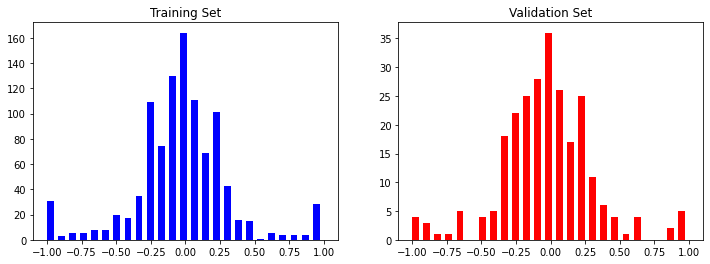

In [13]:
fig,axs=plt.subplots(1,2,figsize=(12,4))
axs[0].hist(y_train,bins=num_bins,width=0.05,color='b')
axs[0].set_title('Training Set')
axs[1].hist(y_valid,bins=num_bins,width=0.05,color='r')
axs[1].set_title('Validation Set')

Affine fuction deals expicitly with affine type transformations which preserves straight lines and planes with the object

In [14]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

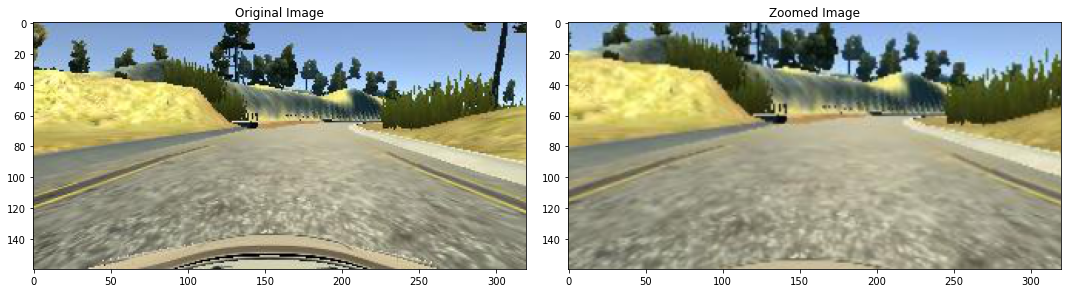

In [15]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
zoom_image=zoom(original_image)
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoom_image)
axs[1].set_title('Zoomed Image')

Image Panning is Horizontal or vertical translation of the Image

In [16]:
def pan(image):
  pan=iaa.Affine(translate_percent={"x":(-0.1,0.1),"y":(-0.1,0.1)})
  image=pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned_Image')

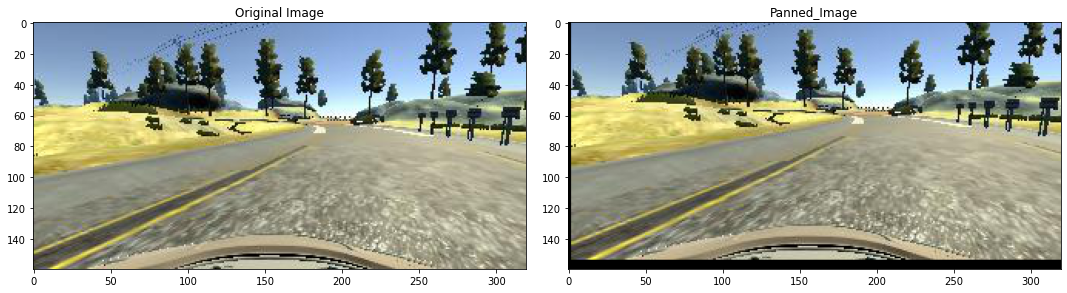

In [17]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
pan_image=pan(original_image)
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(pan_image)
axs[1].set_title('Panned_Image')

Multiply Multipe all the pixel instensities inside the image by a specific value.Thus any Pixel intensity multiplied by a value less than 1 will become darker.Model generally performs better with a higher fraction of darker images.

In [18]:
def brightness(image):
  brightness=iaa.Multiply((0.2,1.2))
  image=brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

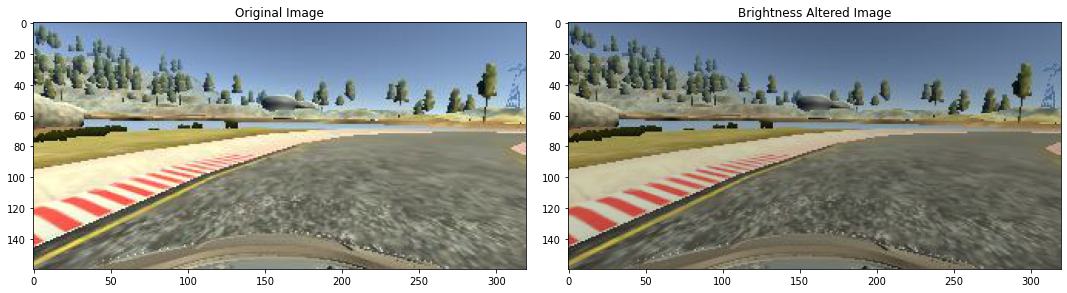

In [19]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
brightness_image=brightness(original_image)
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_image)
axs[1].set_title('Brightness Altered Image')

0 is for vertical flip
1 is for horizontal flip
-1 is for horizontal and vertical flip

In [20]:
def img_flip(image,steering_angle):
  image=cv2.flip(image,1)
  steering_angle=-steering_angle
  return image,steering_angle

Text(0.5, 1.0, 'Flipped ImageSteering Angle:0.2')

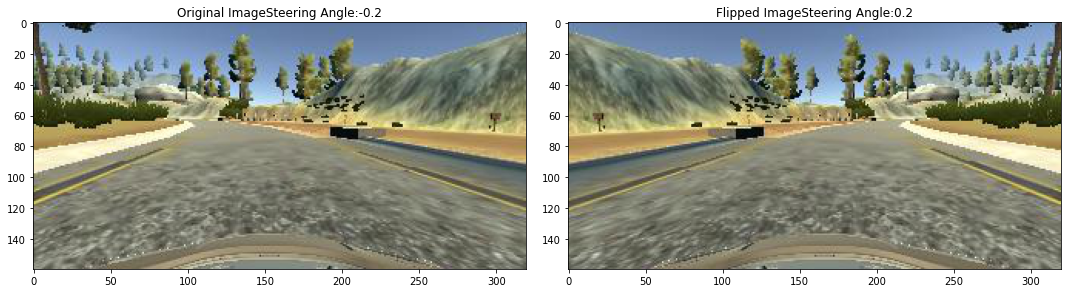

In [21]:
random_index=random.randint(0,1000)
image=image_paths[random_index]
steering_angle=steerings[random_index]
original_image=mpimg.imread(image)
flip_image,flipped_steering_angle=img_flip(original_image,steering_angle)
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image'+'Steering Angle:'+str(steering_angle))
axs[1].imshow(flip_image)
axs[1].set_title('Flipped Image'+'Steering Angle:'+str(flipped_steering_angle))

In [22]:
def random_augment(image,steering_angle):
  image=mpimg.imread(image)
  if np.random.rand()<0.5:
    image=pan(image)
  if np.random.rand()<0.5:
    image=zoom(image)
  if np.random.rand()<0.5:
    image,steering_angle=img_flip(image,steering_angle)
  if np.random.rand()<0.5:
    image=brightness(image)
  return image,steering_angle

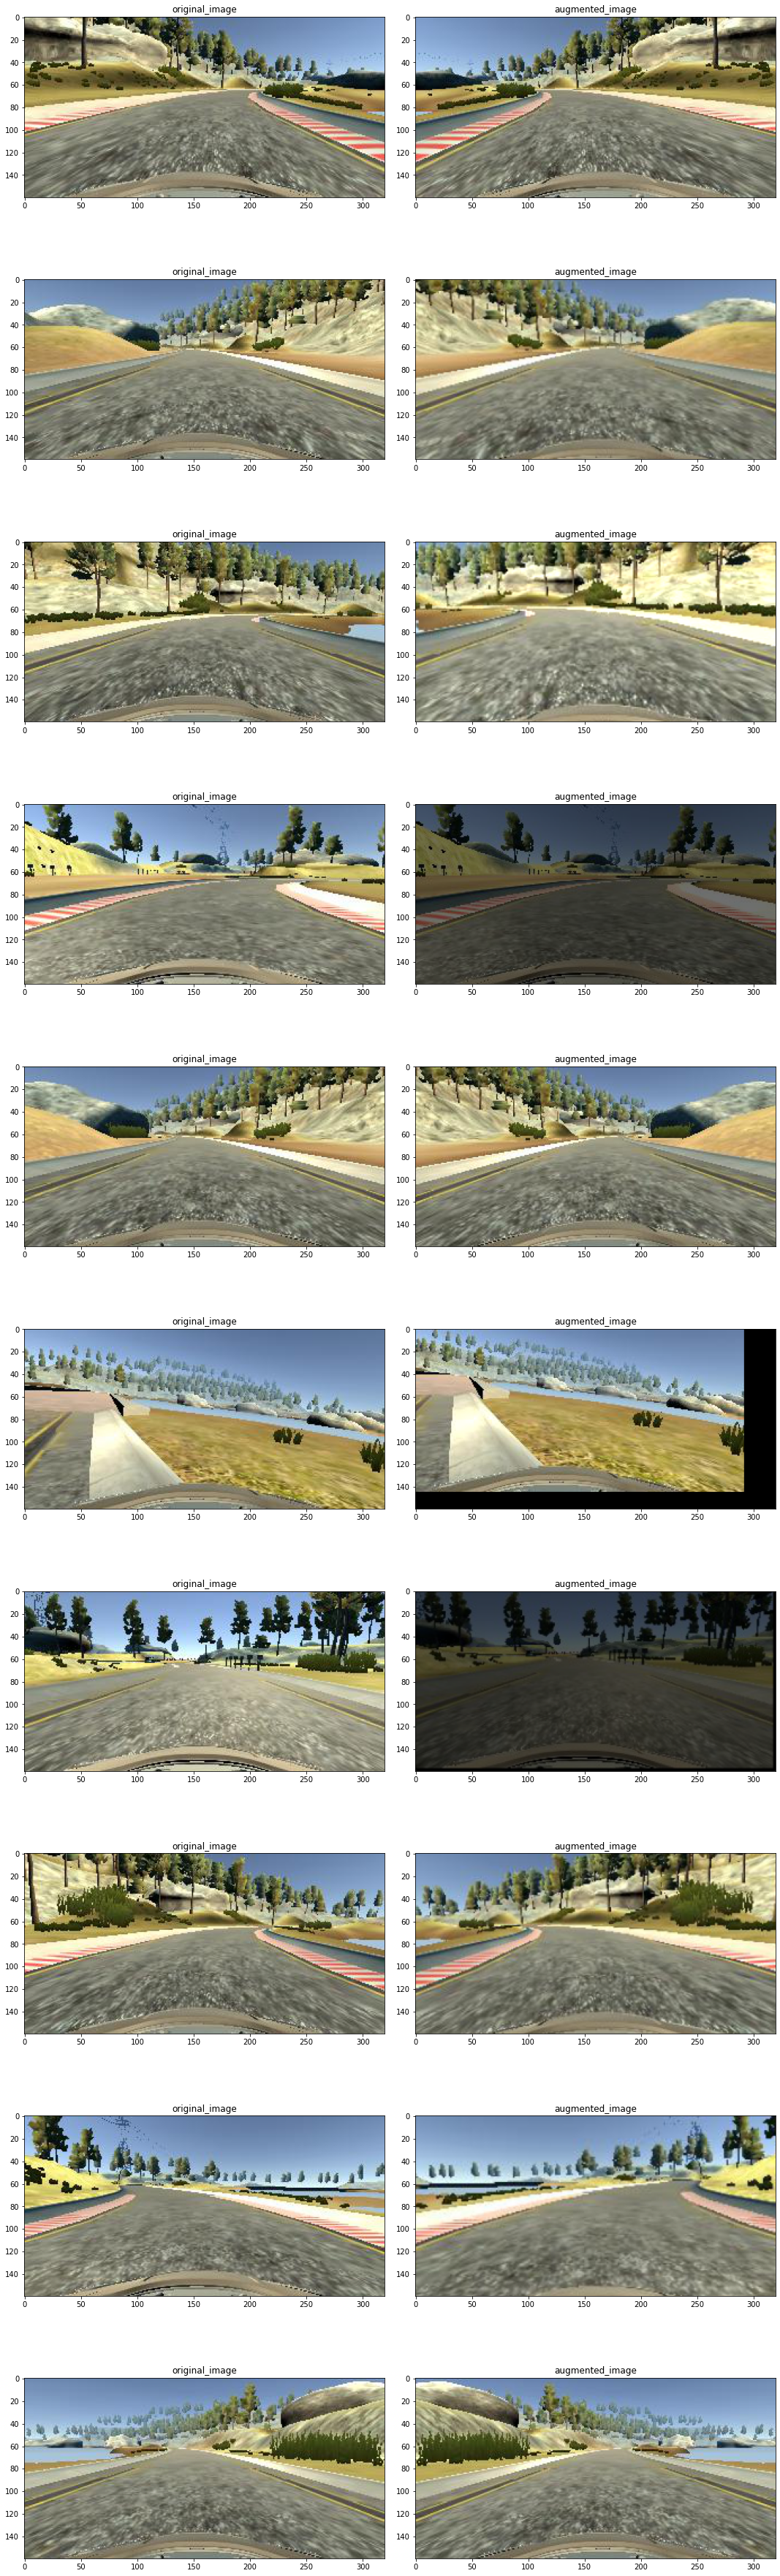

In [23]:
n_cols=2
n_rows=10
fig,axs=plt.subplots(n_rows,n_cols,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum=random.randint(0,len(image_paths)-1)
  random_image=image_paths[randnum]
  random_steering=steerings[randnum]
  original_image=mpimg.imread(random_image)
  augmented_image,augmented_steering=random_augment(random_image,random_steering)
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('original_image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('augmented_image')


In [24]:
def preprocess_image(img):
  # img=mpimg.imread(img)
  img=img[60:135,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img,(3,3),0)
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

mpimg.imread-used for reading image from a given location
img [] 3 coordinates are height width and channel
Nvidia model prefers our image to be in yuv format rather than rgb and grayscale so we preprocess our image accordingly(y reprents the brightness of the image and uv represents chromiums which add color to the image)
Thenn we apply gaussian blur to our image that helps reduce noise in our image and helps smoothen our image then we decrease the size of our image as it helps us in faster computations as a smaller image is easier to work with
(200,66) image is used not only because it is smaller but also because it is the size of image fed in our nvidia model as input images

Text(0.5, 1.0, 'preprocessed_image')

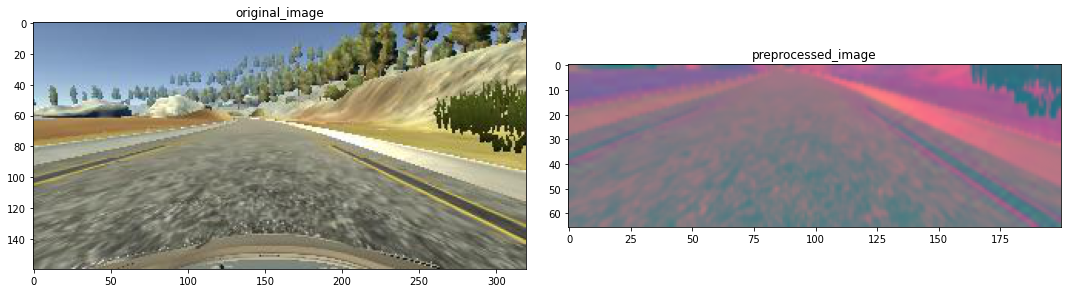

In [25]:
img=image_paths[102]
original_image=mpimg.imread(img)
preprocessed_image=preprocess_image(original_image)
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original_image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed_image')

In [26]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = preprocess_image(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

Text(0.5, 1.0, 'Validation Image')

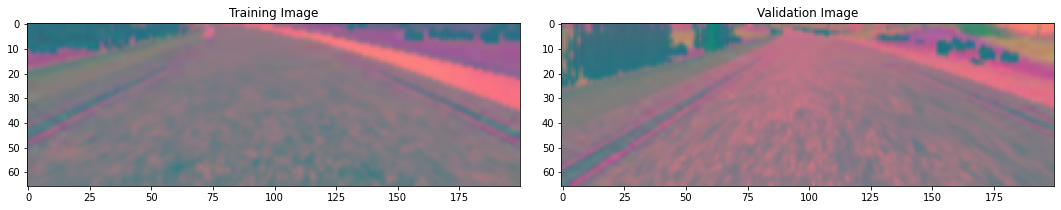

In [27]:
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

NVIDIA MODEL PROPOSED BY NVIDIA IS EFFECTIVE FOR BEHAVIOURAL CLONING

`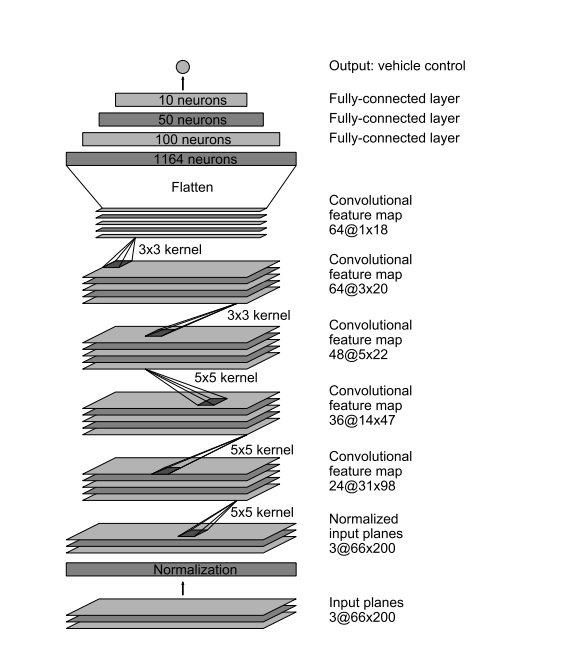

In [28]:
def nvidia_model():
  model=Sequential()
  model.add(Convolution2D(24,(5,5),strides =(2,2),input_shape=(66,200,3),activation='relu'))
  model.add(Convolution2D(36,(5,5),strides =(2,2),activation='elu'))
  model.add(Convolution2D(48,(5,5),strides =(2,2),activation='elu'))
  model.add(Convolution2D(64,(3,3),activation='elu'))
  
  model.add(Convolution2D(64,(3,3),activation='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100,activation='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(50,activation='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(10,activation='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(1))
  model.compile(Adam(lr=1e-4),loss='mse')
  return model

In [29]:
model=nvidia_model() 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [30]:
history = model.fit_generator(batch_generator(x_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(x_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
300/300 [==============================] - 199s 616ms/step - loss: 0.1092 - val_loss: 0.0567
Epoch 2/10
300/300 [==============================] - 184s 617ms/step - loss: 0.0698 - val_loss: 0.0474
Epoch 3/10
300/300 [==============================] - 182s 609ms/step - loss: 0.0627 - val_loss: 0.0397
Epoch 4/10
300/300 [==============================] - 179s 600ms/step - loss: 0.0587 - val_loss: 0.0369
Epoch 5/10
300/300 [==============================] - 179s 599ms/step - loss: 0.0557 - val_loss: 0.0335
Epoch 6/10
300/300 [==============================] - 179s 598ms/step - loss: 0.0542 - val_loss: 0.0335
Epoch 7/10
300/300 [==============================] - 178s 595ms/step - loss: 0.0512 - val_loss: 0.0299
Epoch 8/10
300/300 [==============================] - 178s 595ms/step - loss: 0.0507 - val_loss: 0.0302
Epoch 9/10
300/300 [==============================] - 177s 593ms/step - loss: 0.0481 - val_loss: 0.0300
Epoch 10/10
300/300 [==============================] - 176s 588m

Text(0.5, 1.0, 'Loss')

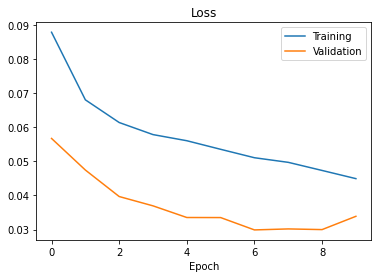

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.xlabel('Epoch')
plt.title('Loss')

In [32]:
model.save('model.h5')

In [33]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>